In [47]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline

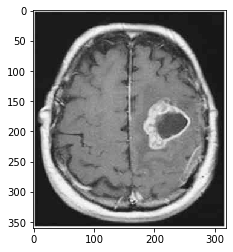

In [9]:
img = cv.imread('Y10.jpg')
plt.imshow(img)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

(<matplotlib.axes._subplots.AxesSubplot at 0x1fc3d635f28>,
 <matplotlib.image.AxesImage at 0x1fc3d68f588>)

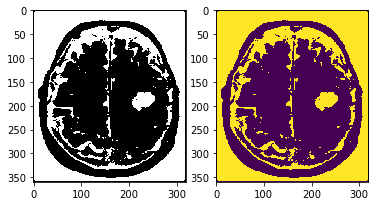

In [33]:
output = [thresh]
plt.subplot(1,2,1),plt.imshow(output[0], 'gray')
plt.subplot(1,2,2),plt.imshow(output[0])

Now we need to remove any small white noises in the image. For that we can use morphological opening. To remove any small holes in the object, we can use morphological closing. So, now we know for sure that region near to center of objects are foreground and region much away from the object are background. Only region we are not sure is the boundary region of brain.

So we need to extract the area which we are sure they are brain. Erosion removes the boundary pixels. So whatever remaining, we can be sure it is brain. That would work if objects were not touching each other. But since they are touching each other, another good option would be to find the distance transform and apply a proper threshold. Next we need to find the area which we are sure they are not coins. For that, we dilate the result. Dilation increases object boundary to background. This way, we can make sure whatever region in background in result is really a background, since boundary region is removed. See the image below.

(<matplotlib.axes._subplots.AxesSubplot at 0x1fc3d571a58>,
 <matplotlib.image.AxesImage at 0x1fc3d5da6a0>)

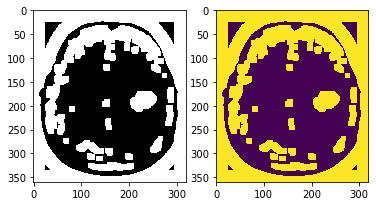

In [32]:
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)
plt.subplot(1,2,1),plt.imshow(unknown, 'gray')
plt.subplot(1,2,2),plt.imshow(unknown)

See the result. In the thresholded image, we get some regions of brain which we are sure of brain(as well as tumor) and they are detached now. (In some cases, you may be interested in only foreground segmentation, not in separating the mutually touching objects. In that case, you need not use distance transform, just erosion is sufficient. Erosion is just another method to extract sure foreground area, that's all.)

Now we know for sure which are region of brain, which are background and all. So we create marker (it is an array of same size as that of original image, but with int32 datatype) and label the regions inside it. The regions we know for sure (whether foreground or background) are labelled with any positive integers, but different integers, and the area we don't know for sure are just left as zero.

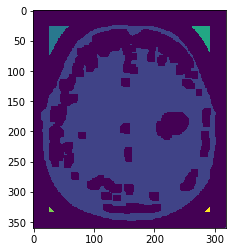

In [35]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers)

The dark blue region shows unknown region.Now our marker is ready. It is time for final step, apply watershed. Then marker image will be modified. The boundary region will be marked with -1.

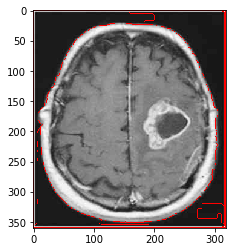

In [46]:
markers = cv.watershed(img,markers)
img[markers == -1] < [255,0,0]
plt.imshow(img)